In [1]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
sys.path.append("../../../python")

import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm

from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
reload(parser)
reload(datatypes)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

Welcome to JupyROOT 6.28/10


In [271]:
data_dir="/home/tomren/geant_projects/musim_test/cedar"
data_dir="/home/tomren/geant_projects/musim_test/cedar_cosmic_n"
fname_comb = f"{data_dir}/series_1_digi_recon_skim.root"

f2 = root.tfile_reader(fname_comb)
f2.ls()

## Get metadata
f2.get_tree("metadata_digi")
metadata_digi = f2.get_entry(0)

# Get data
f2.get_tree("data;1")
print("Entries", f2.entries)

None
Entries 102
TFile**		/home/tomren/geant_projects/musim_test/cedar_cosmic_n/series_1_digi_recon_skim.root	
 TFile*		/home/tomren/geant_projects/musim_test/cedar_cosmic_n/series_1_digi_recon_skim.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TTree	data;1	Reconstruction Tree Skimmed


In [272]:
keys = ["digi_true_track_ids","digi_true_track_nhits", 
        
        "track_nhits", "track_chi2", "track_prob", "track_vabs", 
        "track_residual_6d", "track_error_6d", "track_direction", "track_purity", "track_id", "track_pdg",
        "track_is_primary",
        
        "vertex_ntracks", "vertex_chi2", "vertex_prob", "vertex_residual", "vertex_error", "vertex_residual_longitrans",
        "vertex_is_primary", "vertex_ntracklet_0", "vertex_ntracklet_2", "vertex_ntracklet_3+",
        
        "event_ntracks","event_nhits","event_nvertices",
        "event_ntrack_reconstructable", "event_ntrack_reconstructable_primary", "event_ntrack_recon", "event_vntrk_max"] 

res = {key:[] for key in keys}
cms_coord = [(-70-39/2)*1000, 0, -85.47*1000]

isbreak=False
# for i in range(100):
for i in range(f2.entries):
    if i%100==0:
        print(i, end="\r")
# for i in [1]:
    
    data = f2.get_entry(i)
    event = datatypes.Event(data, metadata_digi)    

    track_is_primary = []
    for j in range(len(event.tracks)):
        t = event.tracks[j]
        res["track_residual_6d"].append(t.params - t.params_truth)
        res["track_error_6d"].append(np.sqrt(np.diagonal(t.cov)))
        res["track_direction"].append(t.iv_index)
        res["track_purity"].append(t.track_purity)
        res["track_id"].append(t.track_id)
        res["track_pdg"].append(t.track_pdg)
        res["track_nhits"].append(t.nhits)
        res["track_chi2"].append(t.chi2)
        res["track_vabs"].append(t.vabs)
        res["track_prob"].append(scipy.stats.chi2.cdf(res["track_chi2"][-1], res["track_nhits"][-1]*3-6))
        track_is_primary.append(False)
        
    
    ntracks=[]
    for j in range(len(event.vertices)):
        v = event.vertices[j]
        res["vertex_ntracks"].append(v.ntracks)
        res["vertex_chi2"].append(v.chi2)
        res["vertex_prob"].append(scipy.stats.chi2.cdf(res["vertex_chi2"][-1], res["vertex_ntracks"][-1]*3-4))
        res["vertex_residual"].append(v.params - event.genvertices.vertices[0])
        res["vertex_error"].append(np.sqrt(np.diagonal(v.cov)))
        res["vertex_ntracklet_0"].append(v.vertex_ntracklet_0)
        res["vertex_ntracklet_2"].append(v.vertex_ntracklet_2)
        res["vertex_ntracklet_3+"].append(v.vertex_ntracklet_3)
        ntracks.append(v.ntracks)

        # Get transversal and longitudinal residual
        residual3 = res["vertex_residual"][-1][:3]
        direction_longi = v.params[:3] - cms_coord
        direction_longi = direction_longi/np.linalg.norm(direction_longi)
        direction_horizontal = np.cross(direction_longi, [0,0,1])
        direction_horizontal = direction_horizontal/np.linalg.norm(direction_horizontal)
        direction_other = np.cross(direction_horizontal,direction_longi)
        res["vertex_residual_longitrans"].append([direction_longi.dot(residual3), direction_horizontal.dot(residual3), direction_other.dot(residual3)])
          

    if (len(ntracks)>0):
        res["event_vntrk_max"].append(np.max(ntracks))
        isprimary = np.zeros_like(ntracks, dtype=bool)
        isprimary[np.argmax(ntracks)] = True
        res["vertex_is_primary"].extend(isprimary)

        vertex_mosttrack = event.vertices[np.argmax(ntracks)]
        for itrack in vertex_mosttrack.track_ids:
            track_is_primary[itrack]  = True
    else:
        res["event_vntrk_max"].append(0)

    res["track_is_primary"].extend(track_is_primary)
        
    res["event_nhits"].append(len(event.tracks))
    res["event_ntracks"].append(len(event.tracks))
    res["event_nvertices"].append(len(event.vertices))
    res["event_ntrack_reconstructable"].append(sum(event.digi_truth_track_nhits>=4))
    res["event_ntrack_reconstructable_primary"].append(sum((event.digi_truth_track_nhits>=4) & (event.digi_truth_track_ids<=len(event.genparticles))))
    res["event_ntrack_recon"].append(len(event.tracks))

for key in res:
    res[key] = np.array(res[key])
res["track_pdg_str"] = np.array([datatypes.PDG.str(i) for i in res["track_pdg"]])

/home/tomren/geant_projects/mathusla-newsim/studies/mathusla40/cosmic_p/../../../python/simhelper/datatypes.py:55: RuntimeWarning: divide by zero encountered in divide
  self.velocity =(np.array([data["Hit_x"][ihit], data["Hit_y"][ihit], data["Hit_z"][ihit]]) -\
/home/tomren/geant_projects/mathusla-newsim/studies/mathusla40/cosmic_p/../../../python/simhelper/datatypes.py:55: RuntimeWarning: invalid value encountered in divide
  self.velocity =(np.array([data["Hit_x"][ihit], data["Hit_y"][ihit], data["Hit_z"][ihit]]) -\


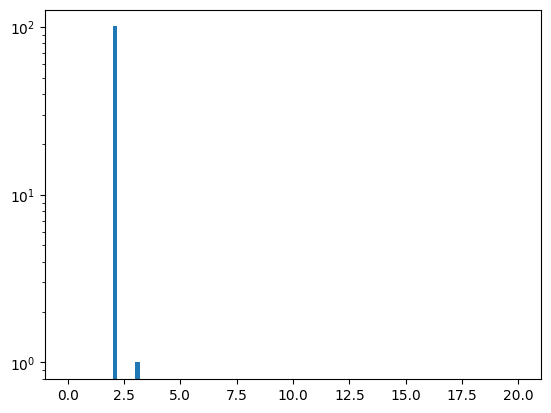

In [273]:
mask = res["vertex_is_primary"]
plt.hist(res["vertex_ntracks"][mask],bins=100,range=(0,20));
plt.yscale("log")



1
100


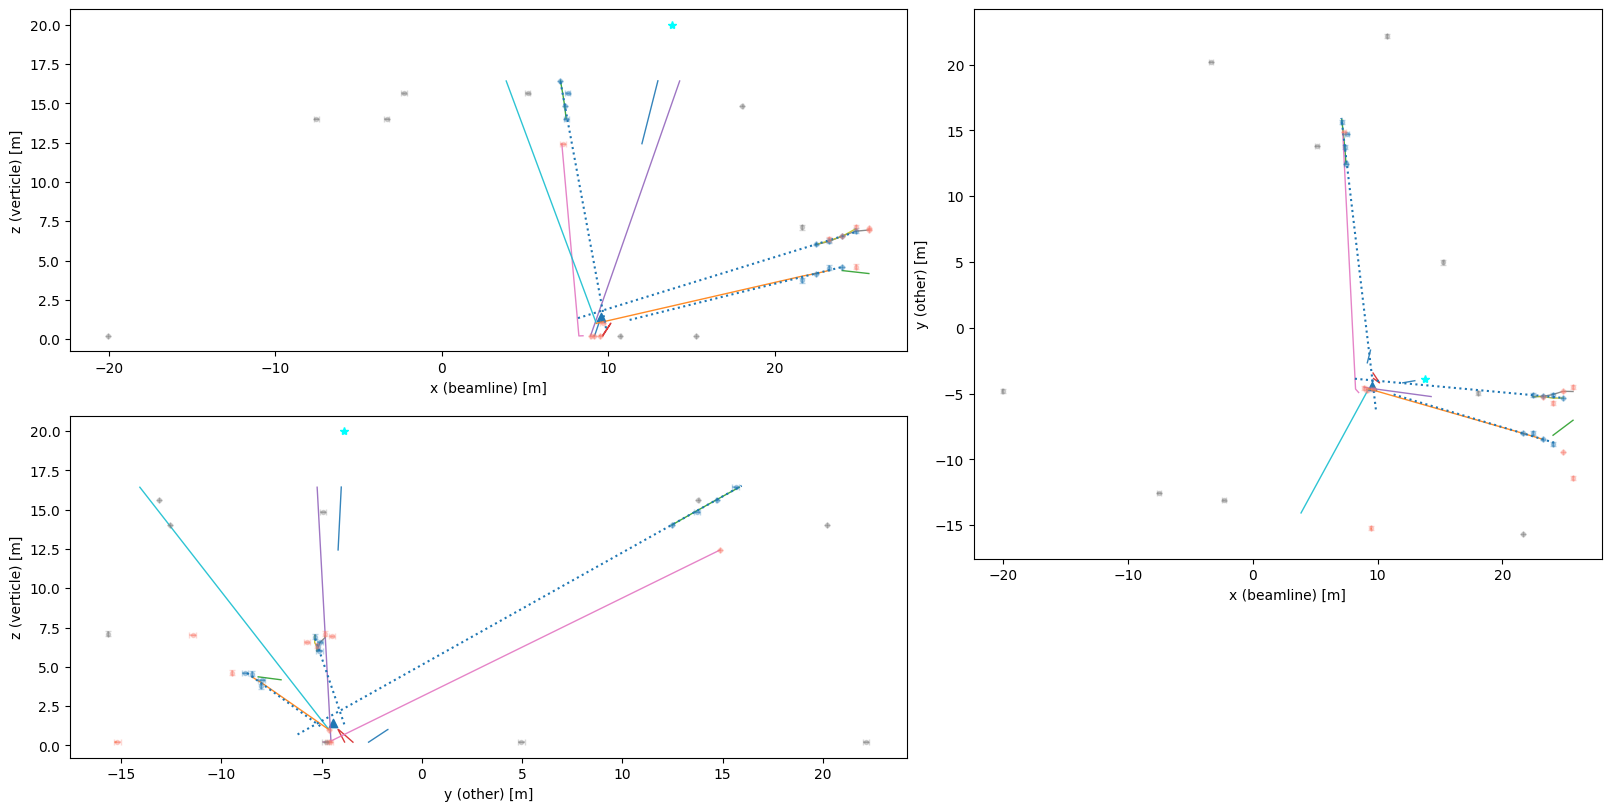

In [274]:
mask = res["vertex_is_primary"] & (res["vertex_ntracks"]>2)
print(sum(mask))
vertex_eventid = np.cumsum( res["vertex_is_primary"])-1
plotinds = vertex_eventid[mask]

i=0
# i+=1
j=plotinds[i]
print(j)

data = f2.get_entry(j)
event = datatypes.Event(data, metadata_digi)  
event.plot()

In [231]:
data["Vertex_trackInds_unpacked"]

[[0, 2, 1], [4, 7], [5, 8]]

In [233]:
5/40

0.125

In [232]:
data["Track_kz"], data["Track_kt"]

([-0.6344266533851624,
  -0.39116233587265015,
  0.02115710638463497,
  -0.7477607727050781,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0.004241821356117725,
  0.003498163539916277,
  0.003972690552473068,
  0.004287319257855415,
  -0.004703065846115351,
  -0.00436626560986042,
  -0.0035951263271272182,
  -0.0041778613813221455,
  -0.0038891516160219908])

In [217]:
i=0
i+=1
j=plotinds[i]
print(i)
data = f2.get_entry(j)

digi_t = np.array(data["Digi_t"])
digi_t_inds = np.argsort(digi_t).astype(int)
digi_t_sorted = digi_t[digi_t_inds]

digi_t_inds = digi_t_inds[digi_t_sorted<np.mean(digi_t_sorted) + 200]
# print(digi_t[digi_t_inds])
ndiv = 4

xs = []
ys = []
zs = []
ts = []
for igroup in range(ndiv):
    inds = digi_t_inds[len(digi_t_inds)//ndiv*igroup: len(digi_t_inds)//ndiv*(igroup+1)]
    xs.append(np.mean(np.array(data["Digi_x"])[inds]))
    ys.append(np.mean(np.array(data["Digi_y"])[inds]))
    zs.append(np.mean(np.array(data["Digi_z"])[inds]))
    ts.append(np.mean(np.array(data["Digi_t"])[inds]))
    # print(np.array(data["Digi_z"])[inds])

zs, xs

1


([9779.249710083008, 14035.099609375, 15635.099609375, 9635.172679901123],
 [-18741.54541015625, -17694.0673828125, -17817.3056640625, 806.25])

In [79]:
data["Track_kt"], data["Track_t0"], data["Vertex_t0"]

([0.0061717857606709,
  -0.004022068344056606,
  0.005835135001689196,
  0.0048088207840919495],
 [-263.46185302734375,
  -366.9369812011719,
  -294.78448486328125,
  -306.8486633300781],
 [-329.5685119628906])

In [23]:
data.keys()

dict_keys(['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Vertex_tracklet_n0', 'Vertex_tracklet_n2', 'Vertex_tracklet_n3', 'Vertex_tracklet_n4p', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index', 'Digi_hitInds_unpacked', 'Track_cov_unpacked', 'Track_digiInds_unpacked', 'Vertex_cov_unpacked', 'Vertex_trackInds_unpacked'])